## Behavioral experiment

In [2]:
# read in data
import matplotlib.pyplot as plt
import jax.random as jr
import cma
import pandas as pd
from memo import memo
import jax
import jax.numpy as np
from enum import IntEnum, auto
# read in files
# Read UK_df.csv as pandas dataframe
original_UK_dialogue = pd.read_csv('UK_df.csv')
original_UK_politeness = pd.read_csv('UK_direct_df.csv')
original_UK_narrator = pd.read_csv('UK_narrator_df.csv')
original_US_dialogue = pd.read_csv('US_df.csv')
original_US_politeness = pd.read_csv('US_direct_df.csv')
original_US_narrator = pd.read_csv('US_narrator_df.csv')
dataframes = [original_UK_dialogue, original_UK_politeness, original_UK_narrator, original_US_dialogue, original_US_politeness, original_US_narrator]
def elim_outliers(df):
    # dropped Unnamed: 0 column
    df.drop(columns=['Unnamed: 0'], inplace=True)
    filtered_df = df.loc[(df['response'] > 95) | (df['response'] < 5)]
    for id in df['person_id'].unique():
        if len(filtered_df[filtered_df['person_id'] == id])/len(df[df['person_id'] == id])>0.8:
            df.drop(df[df['person_id'] == id].index, inplace=True)
    df['predicate Z-score'] = df.groupby(['person_id','predicate'])['response'].transform(lambda x: (x - x.mean()) / x.std())
    # if has_intensifier = no then change 'intensifier' to 'none'
    df.loc[df['has intensifier?'] == 'no', 'intensifier'] = 'none'
    # add valence column where valence is 1 if predicate is in [impressive, understandable, helpful], and -1 otherwise
    df['valence'] = df['predicate'].apply(lambda x: 1 if x in ['impressive', 'understandable', 'helpful'] else -1)
    return df
for i in range(len(dataframes)):
    dataframes[i] = elim_outliers(dataframes[i])
dialogue = pd.concat([dataframes[0], dataframes[3]])
politeness = pd.concat([dataframes[1], dataframes[4]])
UK_dialogue = dataframes[0]
US_dialogue = dataframes[3]
UK_politeness = dataframes[1]
US_politeness = dataframes[4]
UK_narrator = dataframes[2]
US_narrator = dataframes[5]
#-------------------------------------------------------------------------------


In [3]:
# save the dataframes to csv files
import csv
csv.save('UK_dialogue.csv', UK_dialogue)

AttributeError: module 'csv' has no attribute 'save'

Plot figure 1

In [ ]:
def create_graph(UK_df,US_df,title):
    UK_means = UK_df.groupby(['intensifier','predicate'])['Z-Score Difference'].mean()
    US_means = US_df.groupby(['intensifier','predicate'])['Z-Score Difference'].mean()
    UK_means = UK_means.reset_index()
    UK_means = UK_means.groupby(['intensifier'])['Z-Score Difference'].agg(['mean', 'sem', 'count'])
    # for each intensifier get stamdard error of mean
    US_means = US_means.reset_index()
    US_means = US_means.groupby(['intensifier'])['Z-Score Difference'].agg(['mean', 'sem', 'count'])
    x = np.arange(5)  # Positions for the x-axis
    modifier_order = ['slightly','kind of','quite','very', 'extremely']  # Order of intensifiers
    bar_width = 0.35  # Width of the bars
    UK_means = UK_means.loc[modifier_order]
    US_means = US_means.loc[modifier_order]
    fig, ax = plt.subplots(figsize=(10, 6))

    # UK bar plot with error bars
    ax.bar(x - bar_width/2, UK_means['mean'], 
        width=bar_width, 
        yerr=UK_means['sem'], 
        capsize=5, 
        label='UK', 
        color='salmon')

    # US bar plot with error bars
    ax.bar(x + bar_width/2, US_means['mean'], 
        width=bar_width, 
        yerr=US_means['sem'], 
        capsize=5, 
        label='US', 
        color='skyblue')

    # X-axis setup
    ax.set_xticks(x)
    ax.set_xticklabels(modifier_order, rotation=45)
    ax.set_xlabel('Modifier')
    ax.set_ylabel('Mean Value')
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()



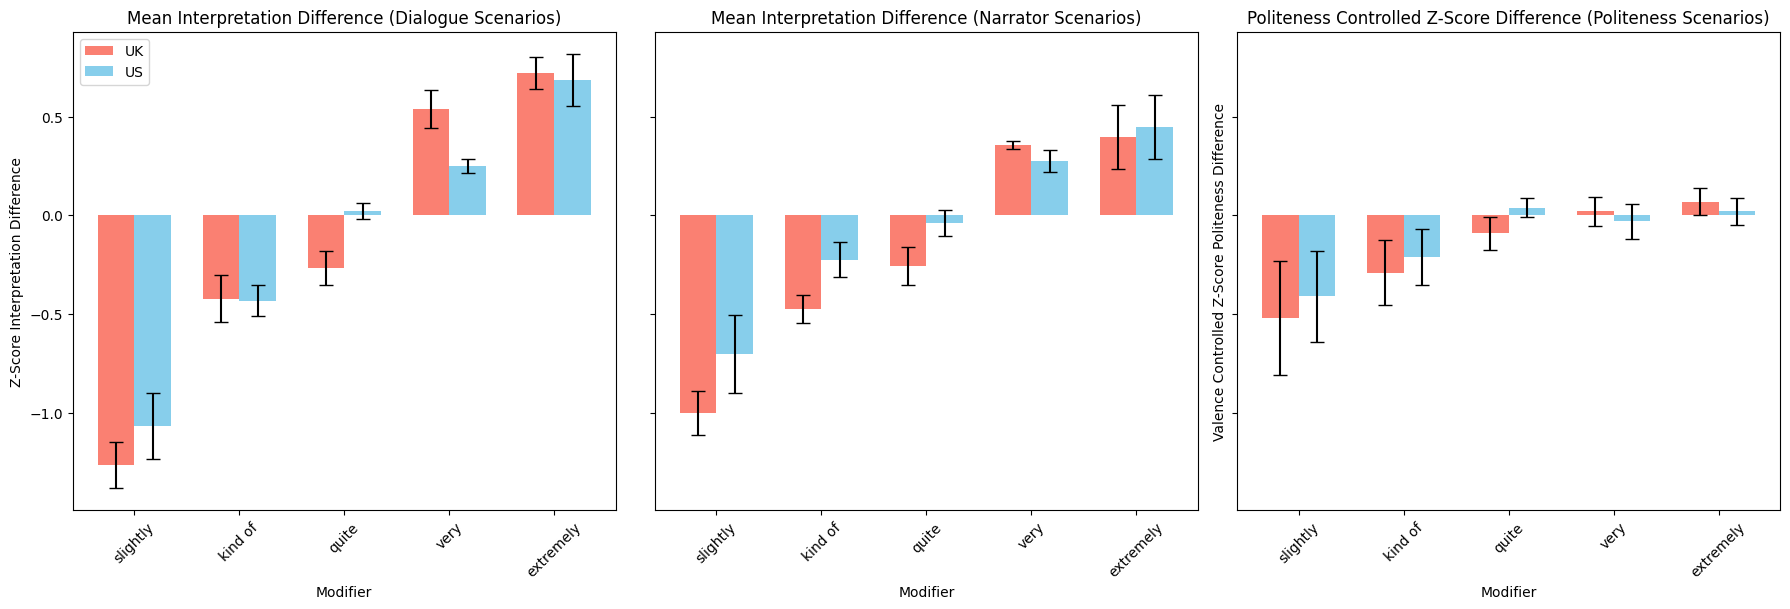

In [ ]:
import matplotlib.pyplot as plt
modifier_order = ['slightly','kind of','quite','very', 'extremely']  # Order of intensifiers
def create_country_means(df):
       means = df.groupby(['intensifier','predicate'])['Z-Score Difference'].mean()
       means = means.reset_index()
       means = means.groupby(['intensifier'])['Z-Score Difference'].agg(['mean', 'sem', 'count'])
       modifier_order = ['slightly','kind of','quite','very', 'extremely']  # Order of intensifiers
       means = means.loc[modifier_order]
       return means
def create_pol_means(pol_df):
    # create a new dataframe with the mean of the Z-score for each predicate and intensifier
    modifier_order = ['slightly','kind of','quite','very', 'extremely']  # Order of intensifiers
    pol_means = pol_df.groupby(['predicate', 'intensifier'])[['Z-Score Difference','valence']].mean()
    pol_means['Politeness Change'] = pol_means['Z-Score Difference'] * pol_means['valence']
    pol_means = pol_means.reset_index()
    pol_means = pol_means.groupby(['intensifier'])['Politeness Change'].agg(['mean', 'sem', 'count'])
    pol_means['mean'] = pol_means['mean'].round(2)
    return pol_means.loc[modifier_order]
x = np.arange(5)  # Positions for the x-axis
bar_width = 0.35  # Width of the bars
fig, axes = plt.subplots(ncols=3, figsize=(18, 6), sharey=True)  # 3 side-by-side plots
UK_means_list = [create_country_means(UK_dialogue),create_country_means(UK_narrator),create_pol_means(UK_politeness)]
US_means_list = [create_country_means(US_dialogue),create_country_means(US_narrator),create_pol_means(US_politeness)]
# Sample titles for each subplot
titles = ['Mean Interpretation Difference (Dialogue Scenarios)', 'Mean Interpretation Difference (Narrator Scenarios)', 'Politeness Controlled Z-Score Difference (Politeness Scenarios)']

for i, ax in enumerate(axes):
       # Replace UK_means and US_means with your actual data per plot
       ax.bar(x - bar_width/2, UK_means_list[i]['mean'], 
              width=bar_width, 
              yerr=UK_means_list[i]['sem'], 
              capsize=5, 
              label='UK', 
              color='salmon')

       ax.bar(x + bar_width/2, US_means_list[i]['mean'], 
              width=bar_width, 
              yerr=US_means_list[i]['sem'], 
              capsize=5, 
              label='US', 
              color='skyblue')

       ax.set_xticks(x)
       ax.set_xticklabels(modifier_order, rotation=45)
       # ax.set_xlabel('Modifier')
       ax.set_title(titles[i])
       if i == 0:
              ax.set_ylabel('Z-Score Interpretation Difference')
              ax.legend()
       if i == 2:
              ax.set_ylabel('Valence Controlled Z-Score Politeness Difference')

plt.tight_layout()

# include x lable for all subplots
for ax in axes:
    ax.set_xlabel('Modifier')
    
plt.savefig('plot.svg', format='svg')
plt.show()


Visualize response distribution

In [6]:
# compute U_soc (social Utility)
U_soc_data = politeness.groupby(['intensifier','predicate'])['predicate Z-score'].mean().to_dict()
UK_U_soc_data = UK_politeness.groupby(['intensifier','predicate'])['predicate Z-score'].mean().to_dict()
US_U_soc_data = US_politeness.groupby(['intensifier','predicate'])['predicate Z-score'].mean().to_dict()
class W(IntEnum):  # utterance space
    # intensifiers
    none = auto(0)
    slightly= auto()
    kind_of = auto()
    quite = auto()
    very= auto()
    extremely= auto()

class P(IntEnum):
    # predicates
    boring = auto(0)
    concerned = auto()
    difficult = auto()
    exhausted = auto()
    helpful = auto()
    impressive = auto()
    understandable = auto()
class C(IntEnum):
    # countries
    UK = auto(0)
    US = auto()
utterences =list(U_soc_data.keys())
easy_S = np.arange(-2.8,2.8,0.1)

# Create a list of JAX arrays
def create_measured_values(dialogue, max_val,score_type):
    measured_values = []
    for p in P:
        for w in W:
            intensifier = w.name.replace('_'," ")
            predicate = p.name
            raw_values = dialogue[((dialogue['intensifier'] == intensifier) & (dialogue['predicate'] == predicate))][score_type].values
            z = [int(r*10)+int(max_val*10) for r in raw_values]
            x = [0]*len(easy_S)
            for i in z:
               x[i] += 1
            measured_values.append(x)
    return np.array(measured_values)
@jax.jit
def state_prior(s):
    return np.exp(-s**2/2) # we assume s is roughly a gaussian distribution
@jax.jit
def U_soc(intensifier,predicate,country):
    arr = jax.lax.cond(country == C.US,
        lambda: np.array([
            [US_U_soc_data[(w.name.replace('_'," "),p.name)] for p in P] 
            for w in W
        ]),
        lambda: np.array([
            [UK_U_soc_data[(w.name.replace('_'," "),p.name)] for p in P]
            for w in W
        ])
    )
    return arr[intensifier,predicate]
@jax.jit
def is_costly(w):
    arr = [0, 1, 1, 1, 1, 1]
    return np.array(arr)[w]

@jax.jit
def L(w, s,t0,t1,t2,t3,t4,t5,v0,v1, v2, v3, v4, v5):  # literal likelihood L(w | s)
    low_t = np.array([t0,t1,t2,t3,t4,t5])[w]
    high_t = low_t + np.array([v0,v1, v2, v3, v4, v5])[w]  # Variance parameters for each intensifier
    s1 = jax.nn.sigmoid(((s - low_t) * 25).astype(float))    
    s2 = jax.nn.sigmoid(((high_t - s) *25).astype(float))
    output = s1 * s2
    return output

@memo
def L1[s: easy_S, w: W](country,inf_term,soc_term,cost,t0,t1,t2,t3,t4,t5,v0,v1, v2, v3, v4, v5,p):
    listener: thinks[
        speaker: given(s in easy_S, wpp=state_prior(s)),
        speaker: chooses(w in W, wpp=
            imagine[
                listener: knows(w),
                listener: chooses(s in easy_S, wpp=L(w, s,t0,t1,t2,t3,t4,t5,v0,v1, v2, v3, v4, v5)*state_prior(s)), # L(w|s) = literal likelihood,
                (Pr[listener.s == s])**(0.3*inf_term)*exp(0.1*soc_term * U_soc(w,p,country) - # U_soc = listener's EU
                cost*is_costly(w)) +0.0000001# U_inf = listener's surprisal       
            ]
        )
    ]
    listener: observes[speaker.w] is w
    listener: chooses(s in easy_S, wpp=Pr[speaker.s == s])
    return Pr[listener.s == s]
UK_measured_values = create_measured_values(UK_dialogue, 2.8,'predicate Z-score')
US_measured_values = create_measured_values(US_dialogue, 2.8,'predicate Z-score')
def US_logloss(*params):
    thetas = params[:6]
    cost = params[6]
    inf_term = params[7]
    soc_term = params[8]
    var = params[9:15]  # Extract the variance parameters
    # g= params[15]
    P_l1 = np.concatenate([L1(country=C.US,inf_term=inf_term, soc_term=soc_term, cost=cost, t0 = thetas[0],t1=thetas[1], t2= thetas[2], t3 = thetas[3], t4 = thetas[4], t5 = thetas[5],v0 = var[0], v1=var[1], v2= var[2], v3 = var[3], v4 = var[4], v5 = var[5], p=p) for p in P],axis = 1)
    return np.sum(np.log(P_l1)*US_measured_values.T)
def UK_logloss(*params):
    thetas = params[:6]
    cost = params[6]
    inf_term = params[7]
    soc_term = params[8]
    var = params[9:15]  # Extract the variance parameters
    # g= params[15]
    P_l1 = np.concatenate([L1(country=C.UK,inf_term=inf_term, soc_term=soc_term, cost=cost, t0 = thetas[0],t1=thetas[1], t2= thetas[2], t3 = thetas[3], t4 = thetas[4], t5 = thetas[5],v0 = var[0], v1=var[1], v2= var[2], v3 = var[3], v4 = var[4], v5 = var[5],p=p) for p in P],axis = 1)
    return np.sum(np.log(P_l1)*UK_measured_values.T)
def easy_wrapped_loss(x):
    result = UK_logloss(*tuple(x)) +US_logloss(*tuple(x))# Unpack the parameters from the tuple
    return -result.item()

## Computational Modeling

Get model prediction of average responses for each predicate and modifier and compare to data

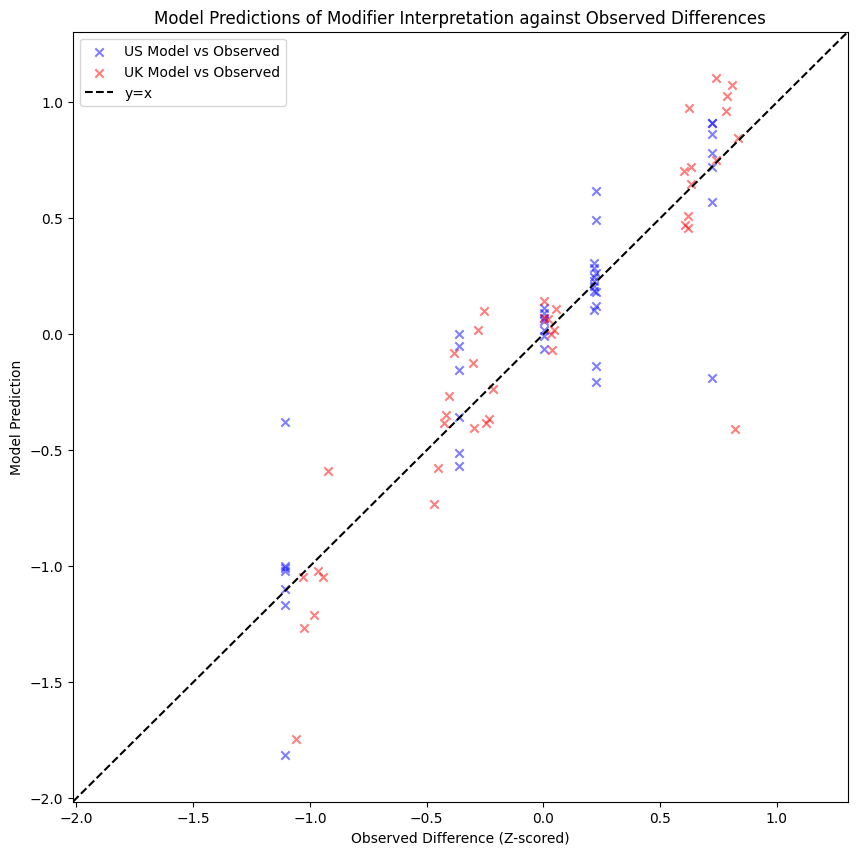

In [ ]:
import matplotlib.pyplot as plt
import jax.numpy as np
# Create a list of JAX arrays
def create_measured_values(dialogue, max_val,score_type):
    measured_values = []
    for p in P:
        for w in W:
            intensifier = w.name.replace('_'," ")
            predicate = p.name
            raw_values = dialogue[((dialogue['intensifier'] == intensifier) & (dialogue['predicate'] == predicate))][score_type].values
            z = [int(r*10)+int(max_val*10) for r in raw_values]
            x = [0]*len(easy_S)
            for i in z:
               x[i] += 1
            measured_values.append(x)
    return np.array(measured_values)
UK_measured_values = create_measured_values(UK_dialogue, 2.8,'predicate Z-score')
US_measured_values = create_measured_values(US_dialogue, 2.8,'predicate Z-score')
# Example data
x_labels = [w.name + " " + p.name for p in P for w in W ]
scenarios = [x.replace("_", " ") for x in x_labels]
y_pos = np.arange(len(scenarios))
bar_height = 0.4

# shuffle UK measured values so 0,7,14,21,28,35,1,8,15,22,29,36,2,9,16,23,30,37,3,10,17,24,31,38,4,11,18,25,32,39,5,12,19,26,33,40,6,13,20,27,34)
response_means = US_measured_values/np.sum(US_measured_values,axis=1,keepdims=True)
US_response_means = np.sum(response_means*easy_S, axis=1, keepdims=False)
params = [0.19804781675338745, 11.309952735900879, -0.97840416431427, 0.647602915763855, 0.4380359947681427, 0.805504322052002, 2.2987690044828923e-06, 0.2366989701986313, 0.00011244539200561121, 0.44379621744155884, 1.5602449178695679, 4.342600345611572, 0.02553415112197399, 0.4821716845035553, 1.2816518545150757]
thetas = params[:6]
cost = params[6]
inf_term = params[7]
soc_term = params[8]
var = params[9:15]  # Extract the variance parameters
P_l1 = np.concatenate([L1(country=C.US,inf_term=inf_term, soc_term=soc_term, cost=cost, t0 = thetas[0],t1=thetas[1], t2= thetas[2], t3 = thetas[3], t4 = thetas[4], t5 = thetas[5],v0 = var[0], v1=var[1], v2= var[2], v3 = var[3], v4 = var[4], v5 = var[5], p=p) for p in P],axis = 1)
US_model_means = P_l1.T/ np.sum(P_l1.T, axis=1, keepdims=True)
US_model_means = np.sum(US_model_means*easy_S, axis=1, keepdims=False)


response_means = UK_measured_values/np.sum(UK_measured_values,axis=1,keepdims=True)
UK_response_means = np.sum(response_means*easy_S, axis=1, keepdims=False)
params = [-0.16125746071338654, -1.5440468788146973, -0.8380383849143982, -0.6727272272109985, 0.25348782539367676, -0.5554113388061523, 1.8896375894546509, 0.37873104214668274, 2.353882312774658, 0.42641380429267883, 1.776790738105774, 1.1575895547866821, 1.0643054246902466, 0.5190290212631226, 5.532210826873779]
thetas = params[:6]
cost = params[6]
inf_term = params[7]
soc_term = params[8]
var = params[9:15]  # Extract the variance parameters
P_l1 = np.concatenate([L1(country=C.UK,inf_term=inf_term, soc_term=soc_term, cost=cost, t0 = thetas[0],t1=thetas[1], t2= thetas[2], t3 = thetas[3], t4 = thetas[4], t5 = thetas[5],v0 = var[0], v1=var[1], v2= var[2], v3 = var[3], v4 = var[4], v5 = var[5], p=p) for p in P],axis = 1)
UK_model_means = P_l1.T/ np.sum(P_l1.T, axis=1, keepdims=True)
UK_model_means = np.sum(UK_model_means*easy_S, axis=1, keepdims=False)
# change order of scenarios, US_response_means, US_model_means, UK_response_means, UK_model_means so that the first 7 are the first 7 scenarios, the next 7 are the next 7 scenarios, and so on
US_response_means = US_response_means[::-1]
US_model_means = US_model_means[::-1]
UK_response_means = UK_response_means[::-1]
UK_model_means = UK_model_means[::-1]
scenarios = scenarios[::-1]
# define the figure size
plt.figure(figsize=(10, 10))
plt.scatter(US_model_means, US_response_means,  color='blue', label='US Model vs Observed', alpha=0.5, marker='x')
plt.scatter(UK_model_means, UK_response_means, color='red', label='UK Model vs Observed', alpha=0.5, marker='x')
# draw y=x line
minimum = min(min(US_response_means), min(UK_response_means), min(US_model_means), min(UK_model_means))
maximum = max(max(US_response_means), max(UK_response_means), max(US_model_means), max(UK_model_means))
plt.xlim(minimum-0.2, maximum+0.2)
plt.ylim(minimum-0.2, maximum+0.2)
plt.plot([-2.8, 2.8], [-2.8, 2.8], color='black', linestyle='--', label='y=x')
# label each point with the scenario name
for i, txt in enumerate(scenarios):
    txt = txt.split(" ")[0]
    if scenarios[i] in ['extremely exhausted','slightly impressive','slightly exhausted','quite concerned','quite helpful']:
        txt = scenarios[i]
    # plt.annotate(txt, (US_response_means[i], US_model_means[i]), fontsize=8, alpha=0.5, rotation=-25)
    # plt.annotate(txt,(UK_response_means[i],UK_model_means[i],), fontsize=8, alpha=0.5, rotation=-25)
plt.legend()
plt.ylabel('Model Prediction')
plt.xlabel('Observed Difference (Z-scored)')
plt.title('Model Predictions of Modifier Interpretation against Observed Differences')
plt.show()



## Code for Model Comparison

In [7]:
# functions to convert the x outputed from the optimization to the respective parameters for x_US and x_UK
def convert_same(x):
    return x,x
def convert_soc(x):
    x_UK = x[:15]
    x_US = np.concatenate([x[:8],x[15:],x[9:15]])
    return x_UK, x_US
def convert_inf(x):
    x_UK = x[:15]
    x_US = np.concatenate([x[:7],x[15:],x[8:15]])
    return x_UK, x_US
def convert_cost(x):
    x_UK = x[:15]
    x_US = np.concatenate([x[:6],x[15:],x[7:15]])
    return x_UK, x_US
def convert_none(x):
    x_UK_mod_low = x[6:7]
    x_UK_mod_var = x[16:17]
    x_UK = np.concatenate([x[:6],x[7:16]])
    x_US = np.concatenate([x_UK_mod_low,x[1:6],x[7:10],x_UK_mod_var,x[11:16]])
    return x_UK, x_US
def convert_slightly(x):
    x_UK_mod_low = x[6:7]
    x_UK_mod_var = x[16:17]
    x_UK = np.concatenate([x[:6],x[7:16]])
    x_US = np.concatenate([x[0:1],x_UK_mod_low,x[2:6],x[7:11],x_UK_mod_var,x[12:16]])
    return x_UK, x_US
def convert_kind_of(x):
    x_UK_mod_low = x[6:7]
    x_UK_mod_var = x[16:17]
    x_UK = np.concatenate([x[:6],x[7:16]])
    x_US = np.concatenate([x[0:2],x_UK_mod_low,x[3:6],x[7:12],x_UK_mod_var,x[13:16]])
    return x_UK, x_US
def convert_quite(x):
    x_UK_mod_low = x[6:7]
    x_UK_mod_var = x[16:17]
    x_UK = np.concatenate([x[:6],x[7:16]])
    x_US = np.concatenate([x[0:3],x_UK_mod_low,x[4:6],x[7:13],x_UK_mod_var,x[14:16]])
    return x_UK, x_US
def convert_very(x):
    x_UK_mod_low = x[6:7]
    x_UK_mod_var = x[16:17]
    x_UK = np.concatenate([x[:6],x[7:16]])
    x_US = np.concatenate([x[0:4],x_UK_mod_low,x[5:6],x[7:14],x_UK_mod_var,x[15:16]])
    return x_UK, x_US
def convert_extremely(x):
    x_UK_mod_low = x[6:7]
    x_UK_mod_var = x[16:17]
    x_UK = np.concatenate([x[:6],x[7:16]])
    x_US = np.concatenate([x[0:5],x_UK_mod_low,x[7:15],x_UK_mod_var])
    return x_UK, x_US
def convert_thresholds(x):
    thresh_UK = x[:6]
    thresh_US = x[6:12]
    var_UK = x[12:18]
    var_US = x[18:24]
    same_params = x[24:28]
    x_UK = np.concatenate([thresh_UK,same_params,var_UK])
    x_US = np.concatenate([thresh_US,same_params,var_US])
    return x_UK, x_US
def convert_UK_US(x):
    return x[:15],x[15:]

converter_list = [
    convert_same,
    convert_soc,
    convert_inf,
    convert_cost,
    # convert_inf_cost,
    convert_none,
    convert_slightly,
    convert_kind_of,
    convert_quite,
    convert_very,
    convert_extremely,
    convert_thresholds,
    convert_UK_US
]

Main Model Comparison

In [9]:
import jax.numpy as np
value_names = ['all_same_v.npy','dif_soc_v.npy','dif_inf_v.npy','dif_cost_v.npy','dif_none_v.npy', 'dif_slightly_v.npy', 'dif_kind_v.npy','29_dif_quite_val.npy','29_dif_very_val.npy','29_dif_extremely_val.npy','Apr29_dif_thresh_val.npy','_all_different']
parameter_names = ['all_same_p.npy','dif_soc_p.npy','dif_inf_p.npy','dif_cost_p.npy','dif_none_p.npy', 'dif_slightly_p.npy', 'dif_kind_p.npy','29_dif_quite_par.npy','29_dif_very_par.npy','29_dif_extremely_par.npy','Apr29_dif_thresh_par.npy','_all_different']
additional_par = np.array([0,1,1,1,2,2,2,2,2,2,3,3,3,3,3,3,12,15])
deg_free = additional_par+15
best_parameters = [
[-0.012559487484395504, -2.124671220779419, -0.9536830186843872, -0.6713522672653198, -0.10348203033208847, -0.5913046598434448, 1.0745415687561035, 0.26845723390579224, 1.4429659843444824, 0.000684923492372036, 1.9108905792236328, 1.0523732900619507, 1.0737062692642212, 0.7825918197631836, 2.9438743591308594] # corresponds to best param for all_same_p
,[-0.013054554350674152, -2.1145272254943848, -0.9532033801078796, -0.6716868281364441, -0.10249855369329453, -0.5859363079071045, 1.073730230331421, 0.26824113726615906, 1.9612157344818115, 0.00025027961237356067, 1.8963514566421509, 1.0497883558273315, 1.075542688369751, 0.7809720635414124, 2.951899290084839, 0.37850022315979004] # corresponds to best param for dif_soc_p
,[0.0011006571585312486, -2.172849655151367, -0.9468163847923279, -0.6756378412246704, 0.054855119436979294, -0.5438717603683472, 1.0832520723342896, 0.29379644989967346, 1.975664496421814, 0.00010198763629887253, 1.970543384552002, 1.0611193180084229, 1.0813161134719849, 0.5979563593864441, 3.0114943981170654, 0.2402171492576599] # corresponds to best param for dif_inf_p
,[-0.011731565929949284, -2.115027904510498, -0.9520349502563477, -0.6740853786468506, -0.1142592802643776, -0.5911800861358643, 1.3974533081054688, 0.2687353789806366, 1.3389151096343994, 0.0008412417955696583, 1.9030357599258423, 1.048136830329895, 1.078999638557434, 0.8026667833328247, 2.9444193840026855, 0.7304027676582336] # corresponds to best param for dif_cost_p
,[0.0014399286592379212, -2.1255598068237305, -0.9538784027099609, -0.6734046339988708, -0.10752539336681366, -0.5955246090888977, -0.02755395881831646, 1.1075924634933472, 0.2696235477924347, 1.4673954248428345, 0.0021779255475848913, 1.917060136795044, 1.0527087450027466, 1.077223300933838, 0.7873408198356628, 2.952974796295166, 0.0004244693845976144] # corresponds to best param for dif_none_p
,[-0.014901746064424515, -2.0916802883148193, -0.9609623551368713, -0.6776819825172424, -0.11284736543893814, -0.5959995985031128, -2.1800029277801514, 1.0417951345443726, 0.2656199634075165, 1.3251409530639648, 0.0016113580204546452, 1.773904800415039, 1.0492786169052124, 1.0774174928665161, 0.7951145768165588, 2.96256160736084, 1.9827944040298462] # corresponds to best param for dif_slightly_p
,[-0.0167531780898571, -2.129859447479248, -0.8839924335479736, -0.6755626797676086, -0.11730540543794632, -0.5990181565284729, -0.9522759318351746, 1.044499397277832, 0.26592838764190674, 1.3271987438201904, 0.0013320782454684377, 1.8975306749343872, 0.7932184338569641, 1.0708099603652954, 0.7968466877937317, 2.9669933319091797, 1.0986292362213135] # corresponds to best param for dif_kind_p
,[0.07698583602905273, 13.930872917175293, -0.9937598705291748,  -0.5628544688224792, 0.8246827721595764, 0.8022475838661194, 0.6475549936294556,1.6889126754904282e-06, 0.24326536059379578, 0.5, 0.6449334621429443, 3.277045726776123, 3.876126527786255,1.248556137084961 ,0.007724455092102289, 5.2132744789123535,0.07641037553548813] # corresponds to best param for dif_quite_p
,[-0.014936133287847042, -2.166004180908203, -0.9574399590492249, -0.675089418888092, 0.6273789405822754, -0.5811190009117126, -0.24630297720432281, 1.025378942489624, 0.2638786733150482, 2.1542470455169678, 0.001044347882270813, 1.9296025037765503, 1.047155499458313, 1.0771621465682983, 1.672882899583783e-05, 2.9544341564178467, 0.6034491062164307] # corresponds to best param for dif_very_p
,[-0.01670192740857601, -2.1324615478515625, -0.9580128192901611, -0.6752839088439941, -0.11404014378786087, -0.5429103374481201, -0.7348141074180603, 1.1140074729919434, 0.2705113887786865, 1.5247248411178589, 0.0009187933756038547, 1.9210939407348633, 1.0540014505386353, 1.0758963823318481, 0.7891262769699097, 4.1767096519470215, 2.903045177459717] # corresponds to best param for dif_extremely_p
,[-0.0005994928651489317, -2.0922765731811523, -0.9291808605194092, -0.766713559627533, 0.6201326847076416, -0.5119233131408691, -0.04934114217758179, -2.27760648727417, -0.970162034034729, -0.46414944529533386, -0.27186161279678345, -0.7868764400482178, 0.0010477410396561027, 1.6628855466842651, 0.8439330458641052, 0.9490289688110352, 0.008814072236418724, 3.230027198791504, 0.003570556640625, 2.036965847015381, 1.0744140148162842, 0.9347469806671143, 0.6259393095970154, 2.997481107711792, 1.0690600872039795, 0.2594439685344696, 1.6380051374435425] # corresponds to best param for dif_thresh_p
,[-0.16125746071338654, -1.5440468788146973, -0.8380383849143982, -0.6727272272109985, 0.25348782539367676, -0.5554113388061523, 1.8896375894546509, 0.37873104214668274, 2.353882312774658, 0.42641380429267883, 1.776790738105774, 1.1575895547866821, 1.0643054246902466, 0.5190290212631226, 5.532210826873779, # corresponds to best param for all_different_p UK params
  0.19804781675338745, 11.309952735900879, -0.97840416431427, 0.647602915763855, 0.4380359947681427, 0.805504322052002, 2.2987690044828923e-06, 0.2366989701986313, 0.00011244539200561121, 0.44379621744155884, 1.5602449178695679, 4.342600345611572, 0.02553415112197399, 0.4821716845035553, 1.2816518545150757] # corresponds to best param for all_different_p US params
]
UKUS_param_list = []
for i,params in enumerate(best_parameters):
    x_UK,x_US = converter_list[i](np.array(params))
    UKUS_param_list.append((x_UK,x_US))
    # break value_names[i] up for each _
    value_names[i] = value_names[i].split('_')
    print("\n")
    print(value_names[i][1],value_names[i][2])
    print("loss when soc is set to 0:" ,UK_logloss(*x_UK.at[8].set(0))+US_logloss(*x_US.at[8].set(0)))
    print("UK:" ,UK_logloss(*x_UK),"US:" ,US_logloss(*x_US))
    print("total:" ,UK_logloss(*x_UK)+US_logloss(*x_US))



same v.npy
loss when soc is set to 0: -11250.725
UK: -5094.9854 US: -6154.9624
total: -11249.947


soc v.npy
loss when soc is set to 0: -11250.678
UK: -5094.96 US: -6154.7954
total: -11249.756


inf v.npy
loss when soc is set to 0: -11245.631
UK: -5087.862 US: -6156.2827
total: -11244.145


cost v.npy
loss when soc is set to 0: -11248.975
UK: -5094.07 US: -6154.2686
total: -11248.338


none v.npy
loss when soc is set to 0: -11250.325
UK: -5094.5093 US: -6155.0063
total: -11249.516


slightly v.npy
loss when soc is set to 0: -11250.319
UK: -5095.405 US: -6154.2744
total: -11249.68


kind v.npy
loss when soc is set to 0: -11249.262
UK: -5094.6875 US: -6153.961
total: -11248.648


dif quite
loss when soc is set to 0: -11225.773
UK: -5095.4795 US: -6130.664
total: -11226.144


dif very
loss when soc is set to 0: -11228.969
UK: -5082.872 US: -6144.4023
total: -11227.274


dif extremely
loss when soc is set to 0: -11249.967
UK: -5094.515 US: -6154.625
total: -11249.141


dif thresh
loss wh